In [1]:
import numpy as np
import pandas as pd
import gensim
import logging
import re

import nltk.data
from nltk.corpus import stopwords
import nltk

from nltk.stem.porter import *
from __future__ import division
from sklearn.feature_extraction.text import TfidfVectorizer
import codecs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import sys
stemmer = PorterStemmer()





C:\Users\PRPC\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [3]:
from gensim.models import word2vec

In [4]:
import gensim



In [7]:
stops = set(stopwords.words("english"))

In [8]:
## Reading Lexicons
stock_lex = pd.read_csv('stock_lex.csv',sep=',')
def split_words(x):
    x =  re.sub("[^a-zA-Z]"," ", x)
    s = x.split()
    words = [w for w in s if len(w) > 1]
    return ' '.join(words)
stock_lex['cleanItem'] = stock_lex['Item'].apply(split_words)
stock_lex = stock_lex[stock_lex['cleanItem'] != '']

In [200]:
stock_lex.shape


(20336, 5)

In [10]:
import random
random.seed(2)

In [11]:
training_data = pd.read_json(codecs.open('Microblog_Trainingdata.json', 'r', 'utf-8'),orient='records')

In [37]:
test_data = pd.read_json(codecs.open('Microblogs_Testdata.json', 'r', 'utf-8'),orient='records')

In [14]:
# test_data.shape

In [202]:
## Test data Removing the rows with empty span 
filters = test_data['spans'] != ''
test_data = test_data[filters]
test_data.shape

(790, 7)

In [16]:
# test_data.head(2)

In [17]:
def cleanText(text):
    text = str(text).encode("utf-8").decode('utf-8')
    newtext = ' '.join(re.sub("(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)"," ",text).lower().split())
    newt = newtext.split()
    words = [w for w in newt if len(w) > 2]
    return ' '.join(words)

In [18]:
def merge_spans(train):
        merged_spans = []
        for index,row in train.iterrows():
            if row['spans'][0] != '':
                merged_spans.append(cleanText(" ".join(row['spans'])))
            else:
                merged_spans.append(cleanText(row['spans']))
        return merged_spans

In [19]:
training_data['merged_spans'] = merge_spans(training_data)

In [20]:
training_data['tokenized_sents'] = training_data.apply(lambda row: nltk.word_tokenize(row['merged_spans']), axis=1)

In [21]:
## Test data Removing the rows with empty span 
train_filters = training_data['merged_spans'] != ''
training_data = training_data[train_filters]
training_data.shape

(1673, 7)

In [42]:
def merge_spans_test(test):
        merged_spans = []
        for index,row in test.iterrows():
            if row['spans'] != '':
                merged_spans.append(cleanText(row['spans']))
            else:
                merged_spans.append(cleanText(row['spans']))
        return merged_spans

In [43]:
test_data['merged_spans'] = merge_spans_test(test_data)

In [44]:
test_data.head(3)

,cashtag,id,source,spans,merged_spans
0,$COST,709723193125175300,twitter,consumers keep cautious stance,consumers keep cautious stance
1,$CTRP,719529094652698600,twitter,Close $CTRP @46.16 from 43.55 entry +6%;$;+6%,close ctrp from entry
2,$INTC,39048670,stocktwits,Every Reason to Be Bullish,every reason bullish


In [22]:
training_data.rename(columns={'sentiment score': 'sentimentscore'}, inplace=True)

In [23]:
training_data.head(3)

,cashtag,id,sentimentscore,source,spans,merged_spans,tokenized_sents
0,$FB,719659409228451840,0.366,twitter,[watching for bounce tomorrow],watching for bounce tomorrow,"[watching, for, bounce, tomorrow]"
1,$LUV,719904304207962112,0.638,twitter,[record number of passengers served in 2015],record number passengers served,"[record, number, passengers, served]"
2,$NFLX,5329774,-0.494,stocktwits,[out $NFLX -.35],out nflx,"[out, nflx]"


In [50]:
def compute_stock_score(text):
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    pos_score = 0
    neg_score = 0
    for i in range(0,len(tagged)):
        word = tagged[i]
        if word[1] != 'NNP':
            for index,row in stock_lex.iterrows():
                if word[0] == row['cleanItem'] and word[1] == row['POS']:
                    pos_score = pos_score+row['Aff_Score']
                    neg_score = neg_score+row['Neg_Score']
                    break
                else:
                    if i > 0:
                        prev = tagged[i-1]
                        words = row['cleanItem'].split()
                        if len(words)>1:
                            if prev[0] == words[0] and word[0] == words[1]:
                                pos_score = pos_score+row['Aff_Score']
                                neg_score = neg_score+row['Neg_Score']
                                break
    return pos_score,neg_score

In [51]:
# Computing Lexicon Scores Training Data
pos_score = []
neg_score = []
for index,row in training_data.iterrows():
    print(index)
    p,n = compute_stock_score(row['merged_spans'])
    pos_score.append(p)
    neg_score.append(n)
training_data['stockLex_Pos'] = pos_score
training_data['stockLex_Neg'] = neg_score

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
72
73
74
75
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
208
209
210
211
212
213
214
215
216
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
273
274
275
276
277
278
279
280
281
282
283

In [53]:
# Reading dictionary
logran_dict = pd.read_csv('lougran.csv',sep=',')

In [54]:
pos_lougran = []
neg_lougran = []
for index,row in logran_dict.iterrows():
    print(index)
    if row['Positive'] == 2009:
        pos_lougran.append(row['Word'].lower())
    if row['Negative'] == 2009:
        neg_lougran.append(row['Word'].lower())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780


5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968


8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361


11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
11270
11271
11272
11273
11274
11275
11276
11277
11278
11279
11280
11281
11282
11283
11284
11285
11286
11287
11288
11289
11290
11291
11292
11293
11294
11295
11296
11297
11298
11299
11300
11301
11302
11303
11304
11305
11306
11307
11308
11309
11310
11311
11312
11313
11314
11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11354
11355
11356
11357
11358
11359
11360
11361
11362
11363
11364
11365
11366
11367
11368
11369
11370
11371
11372
11373
11374
11375
11376
11377
11378
1137

13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939
13940
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952
13953
13954
13955
13956
13957
13958
13959
13960
13961
13962
13963
13964
13965
13966
13967
13968
13969
13970
13971
13972
13973
13974
13975
13976
13977
13978
13979
13980
13981
13982
13983
13984
13985
13986
13987
13988
13989
13990
13991
13992
13993
13994
13995
13996
1399

15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009
16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
1602

18556
18557
18558
18559
18560
18561
18562
18563
18564
18565
18566
18567
18568
18569
18570
18571
18572
18573
18574
18575
18576
18577
18578
18579
18580
18581
18582
18583
18584
18585
18586
18587
18588
18589
18590
18591
18592
18593
18594
18595
18596
18597
18598
18599
18600
18601
18602
18603
18604
18605
18606
18607
18608
18609
18610
18611
18612
18613
18614
18615
18616
18617
18618
18619
18620
18621
18622
18623
18624
18625
18626
18627
18628
18629
18630
18631
18632
18633
18634
18635
18636
18637
18638
18639
18640
18641
18642
18643
18644
18645
18646
18647
18648
18649
18650
18651
18652
18653
18654
18655
18656
18657
18658
18659
18660
18661
18662
18663
18664
18665
18666
18667
18668
18669
18670
18671
18672
18673
18674
18675
18676
18677
18678
18679
18680
18681
18682
18683
18684
18685
18686
18687
18688
18689
18690
18691
18692
18693
18694
18695
18696
18697
18698
18699
18700
18701
18702
18703
18704
18705
18706
18707
18708
18709
18710
18711
18712
18713
18714
18715
18716
18717
18718
18719
18720
18721
1872

20820
20821
20822
20823
20824
20825
20826
20827
20828
20829
20830
20831
20832
20833
20834
20835
20836
20837
20838
20839
20840
20841
20842
20843
20844
21287
21288
21289
21290
21291
21292
21293
21294
21295
21296
21297
21298
21299
21300
21301
21302
21303
21304
21305
21306
21307
21308
21309
21310
21311
21312
21313
21314
21315
21316
21317
21318
21319
21320
21321
21322
21323
21324
21325
21326
21327
21328
21329
21330
21331
21332
21333
21334
21335
21336
21337
21338
21339
21340
21341
21342
21343
21344
21345
21346
21347
21348
21349
21350
21351
21352
21353
21354
21355
21356
21357
21358
21359
21360
21361
21362
21363
21364
21365
21366
21367
21368
21369
21370
21371
21372
21373
21374
21375
21376
21377
21378
21379
21380
21381
21382
21383
21384
21385
21386
21387
21388
21389
21390
21391
21392
21393
21394
21395
21396
21397
21398
21399
21400
21401
21402
21403
21404
21405
21406
21407
21408
21409
21410
21411
21412
21413
21414
21415
21416
21417
21418
21419
21420
21421
21422
21423
21424
21425
21426
21427
2142

24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033
24034
24035
24036
24037
24038
24039
24040
24041
24042
24043
24044
24045
24046
24047
24048
24049
24050
24051
24052
24053
24054
24055
24056
24057
24058
24059
24060
24061
24062
24063
24064
24065
24066
24067
24068
24069
24070
24071
24072
24073
24074
24075
24076
24077
24078
24079
24080
24081
24082
24083
24084
24085
24086
24087
24088
24089
24090
24091
24092
24093
24094
24095
24096
24097
24098
24099
24100
24101
24102
24103
24104
24105
24106
24107
24108
24109
24110
24111
24112
24113
24114
24115
24116
24117
24118
24119
24120
24121
24122
24123
24124
24125
24126
24127
24128
24129
24130
24131
24132
24133
24134
24135
24136
24137
24138
24139
24140
24141
24142
24143
24144
24145
24146
24147
24148
24149
24150
24151
24152
24153
24154
24155
24156
24157
24158
24159
24160
24161
24162
24163
24164
24165
24166
24167
24168
24169
24170
24171
24172
24596
24597
24598
24599
24600
24601
2460

26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
26760
26761
26762
26763
26764
26765
26766
26767
26768
26769
26770
26771
26772
26773
26774
26775
26776
26777
26778
26779
26780
26781
26782
26783
26784
26785
26786
26787
26788
26789
26790
26791
26792
26793
26794
26795
26796
26797
26798
26799
26800
26801
26802
26803
26804
2680

29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
29470
29471
29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521
29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
29534
29535
29536
29537
29538
29539
29540
29541
29542
29543
29544
29545
29546
29547
29548
29549
29550
29551
29552
29553
29554
29555
29556
29557
29558
29559
29560
29561
29562
29563
29564
29565
29566
29567
29568
29569
29570
2957

31636
31637
31638
31639
31640
31641
31642
31643
31644
31645
31646
31647
31648
31649
31650
31651
31652
31653
31654
31655
31656
31657
31658
31659
31660
31661
31662
31663
31664
31665
31666
31667
31668
31669
31670
31671
31672
31673
31674
31675
31676
31677
31678
31679
31680
31681
31682
31683
31684
31685
31686
31687
31688
31689
31690
31691
31692
31693
31694
31695
31696
31697
31698
31699
31700
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
32270
32271
32272
32273
32274
32275
32276
32277
32278
32279
32280
32281
32282
32283
32284
32285
32286
32287
32288
32289
32290
32291
32292
32293
32294
32295
32296
32297
32298
32299
32300
3230

34439
34440
34441
34442
34443
34444
34445
34446
34447
34448
34449
34450
34451
34452
34453
34454
34455
34456
34457
34458
34459
34460
34461
34462
34463
34464
34465
34466
34467
34468
34469
34470
34471
34472
34473
34474
34475
34476
34477
34478
34479
34480
34481
34482
34483
34484
34485
34486
34487
34488
34489
34490
34491
34492
34493
34494
34495
34496
34497
34498
34499
34500
34501
34502
34503
34504
34505
34506
34507
34508
34509
34510
34511
34512
34513
34514
34515
34516
34517
34518
34519
34520
34521
34522
34523
34524
34525
34526
34527
34528
34529
34530
34531
34532
34533
34534
34535
34536
34537
34538
34539
34540
34541
34542
34543
34544
34545
34546
34547
34548
34549
34550
34551
34552
34553
34554
34555
34556
34557
34558
34559
34560
34561
34562
34563
34564
34565
34566
34567
34568
34569
34570
34571
34572
34573
34574
34575
34576
34577
34578
34579
34580
34581
34582
34583
34584
34585
34586
34587
34588
34589
34590
34591
34592
34593
34594
34595
34596
34597
34598
34599
34600
34601
34602
34603
34604
3460

36788
36789
36790
36791
36792
36793
36794
36795
36796
36797
36798
36799
36800
36801
36802
36803
36804
36805
36806
36807
36808
36809
36810
36811
36812
36813
36814
36815
36816
36817
36818
36819
36820
36821
36822
36823
36824
36825
36826
36827
36828
36829
36830
36831
36832
36833
36834
36835
36836
36837
36838
36839
36840
36841
36842
36843
36844
36845
36846
36847
36848
36849
36850
36851
36852
36853
36854
36855
36856
36857
36858
36859
36860
36861
36862
36863
36864
36865
36866
36867
36868
36869
36870
36871
3687237114
37115
37116
37117
37118
37119
37120
37121
37122
37123
37124
37125
37126
37127
37128
37129
37130
37131
37132
37133
37134
37135
37136
37137
37138
37139
37140
37141
37142
37143
37144
37145
37146
37147
37148
37149
37150
37151
37152
37153
37154
37155
37156
37157
37158
37159
37160
37161
37162
37163
37164
37165
37166
37167
37168
37169
37170
37171
37172
37173
37174
37175
37176
37177
37178
37179
37180
37181
37182
37183
37184
37185
37186
37187
37188
37189
37190
37191
37192
37193
37194
37195

39365
39366
39367
39368
39369
39370
39371
39372
39373
39374
39375
39376
39377
39378
39379
39380
39381
39382
39383
39384
39385
39386
39387
39388
39389
39390
39391
39392
39393
39394
39395
39396
39397
39398
39399
39400
39401
39402
39403
39404
39405
39406
39407
39408
39409
39410
39411
39412
39413
39414
39415
39416
39417
39418
39419
39420
39421
39422
39423
39424
39425
39426
39427
39428
39429
39430
39431
39432
39433
39434
39435
39436
39437
39438
39439
39440
39441
39442
39443
39444
39445
39446
39447
39448
39449
39450
39451
39452
39453
39454
39455
39456
39457
39458
39459
39460
39461
39462
39463
39464
39465
39466
39467
39468
39469
39470
39471
39472
39473
39474
39475
39476
39477
39478
39479
39480
39481
39482
39483
39484
39485
39486
39487
39488
39489
39490
39491
39492
39493
39494
39495
39496
39497
39498
39499
39500
39501
39502
39503
39504
39505
39506
39507
39508
39509
39510
39511
39512
39513
39514
39515
39516
39517
39518
39519
39520
39521
39522
39523
39524
39525
39526
39527
39528
39529
39530
3953

42185
42186
42187
42188
42189
42190
42191
42192
42193
42194
42195
42196
42197
42198
42199
42200
42201
42202
42203
42204
42205
42206
42207
42208
42209
42210
42211
42212
42213
42214
42215
42216
42217
42218
42219
42220
42221
42222
42223
42224
42225
42226
42227
42228
42229
42230
42231
42232
42233
42234
42235
42236
42237
42238
42239
42240
42241
42242
42243
42244
42245
42246
42247
42248
42249
42250
42251
42252
42253
42254
42255
42256
42257
42258
42259
42260
42261
42262
42263
42264
42265
42266
42267
42268
42269
42270
42271
42272
42273
42274
42275
42276
42277
42278
42279
42280
42281
42282
42283
42284
42285
42286
42287
42288
42289
42290
42291
42292
42293
42294
42295
42296
42297
42298
42299
42300
42301
42302
42303
42304
42305
42306
42307
42308
42309
42310
42311
42312
42313
42314
42315
42316
42317
42318
42319
42320
42321
42322
42323
42324
42325
42326
42327
42328
42329
42330
42331
42332
42333
42334
42335
42336
42337
42338
42339
42340
42341
42342
42343
42344
42345
42346
42347
42348
42349
42350
4235

45376
45377
45378
45379
45380
45381
45382
45383
45384
45385
45386
45387
45388
45389
45390
45391
45392
45393
45394
45395
45396
45397
45398
45399
45400
45401
45402
45403
45404
45405
45406
45407
45408
45409
45410
45411
45412
45413
45414
45415
45416
45417
45418
45419
45420
45421
45422
45423
45424
45425
45426
45427
45428
45429
45430
45431
45432
45433
45434
45435
45436
45437
45438
45439
45440
45441
45442
45443
45444
45445
45446
45447
45448
45449
45450
45451
45452
45453
45454
45455
45456
45457
45458
45459
45460
45461
45462
45463
45464
45465
45466
45467
45468
45469
45470
45471
45472
45473
45474
45475
45476
45477
45478
45479
45480
45481
45482
45483
45484
45485
45486
45487
45488
45489
45490
45491
45492
45493
45494
45495
45496
45497
45498
45499
45500
45501
45502
45503
45504
45505
45506
45507
45508
45509
45510
45511
45512
45513
45514
45515
45516
45517
45518
45519
45520
45521
45522
45523
45524
45525
45526
45527
45528
45529
45530
45531
45532
45533
45534
45535
45536
45537
45538
45539
45540
45541
4554

47983
47984
47985
47986
47987
47988
47989
47990
47991
47992
47993
47994
47995
47996
47997
47998
47999
48000
48001
48002
48003
48004
48005
48006
48007
48008
48009
48010
48011
48012
48013
48014
48015
48016
48017
48018
48019
48020
48021
48022
48023
48024
48025
48026
48027
48028
48029
48030
48031
48032
48033
48034
48035
48036
48037
48038
48039
48040
48041
48042
48043
48044
48045
48046
48047
48048
48049
48050
48051
48052
48053
48054
48055
48056
48057
48058
48059
48060
48061
48062
48063
48064
48065
48066
48067
48068
48069
48070
48071
48072
48073
48074
48075
48076
48077
48078
48079
48080
48081
48082
48083
48084
48085
48086
48087
48088
48089
48090
48091
48092
48093
48094
48095
48096
48097
48098
48099
48100
48101
48102
48103
48104
48105
48106
48107
48626
48627
48628
48629
48630
48631
48632
48633
48634
48635
48636
48637
48638
48639
48640
48641
48642
48643
48644
48645
48646
48647
48648
48649
48650
48651
48652
48653
48654
48655
48656
48657
48658
48659
48660
48661
48662
48663
48664
48665
48666
4866

50820
50821
50822
50823
50824
50825
50826
50827
50828
50829
50830
50831
50832
50833
50834
50835
50836
50837
50838
50839
50840
50841
50842
50843
50844
50845
50846
50847
50848
50849
50850
50851
50852
50853
50854
50855
50856
50857
50858
50859
50860
50861
50862
50863
50864
50865
50866
50867
50868
50869
50870
50871
50872
50873
50874
50875
50876
50877
50878
50879
50880
50881
50882
50883
50884
50885
50886
50887
50888
50889
50890
50891
50892
50893
50894
50895
50896
50897
50898
50899
50900
50901
50902
50903
50904
50905
50906
50907
50908
50909
50910
50911
50912
50913
50914
50915
50916
50917
50918
50919
50920
50921
50922
50923
50924
50925
50926
50927
50928
50929
50930
50931
50932
50933
50934
50935
50936
50937
50938
50939
50940
50941
50942
50943
50944
50945
50946
50947
50948
50949
50950
50951
50952
50953
50954
50955
50956
50957
50958
50959
50960
50961
50962
50963
50964
50965
50966
50967
50968
50969
50970
50971
50972
50973
50974
50975
50976
50977
50978
50979
50980
50981
50982
50983
50984
50985
5098

53466
53467
53468
53469
53470
53471
53472
53473
53474
53475
53476
53477
53478
53479
53480
53481
53482
53483
53484
53485
53486
53487
53488
53489
53490
53491
53492
53493
53494
53495
53496
53497
53498
53499
53500
53501
53502
53503
53504
53505
53506
53507
53508
53509
53510
53511
53512
53513
53514
53515
53516
53517
53518
53519
53520
53521
53522
53523
53524
53525
53526
53527
53528
53529
53530
53531
53532
53533
53534
53535
53536
53537
53538
53539
53540
53541
53542
53543
53544
53545
53546
53547
53548
53549
53550
53551
53552
53553
53554
53555
53556
53557
53558
53559
53560
53561
53562
53563
53564
53565
53566
53567
53568
53569
53570
53571
53572
53573
53574
53575
53576
53577
53578
53579
53580
53581
53582
53583
53584
53585
53586
53587
53588
53589
53590
53591
53592
53593
53594
53595
53596
53597
53598
53599
53600
53601
53602
53603
53604
53605
53606
53607
53608
53609
53610
53611
53612
53613
53614
53615
53616
53617
53618
53619
53620
53621
53622
53623
53624
53625
53626
53627
53628
53629
53630
53631
5363

55745
55746
55747
55748
55749
55750
55751
55752
55753
55754
55755
55756
55757
55758
55759
55760
55761
55762
55763
55764
55765
55766
55767
55768
55769
55770
55771
55772
55773
55774
56239
56240
56241
56242
56243
56244
56245
56246
56247
56248
56249
56250
56251
56252
56253
56254
56255
56256
56257
56258
56259
56260
56261
56262
56263
56264
56265
56266
56267
56268
56269
56270
56271
56272
56273
56274
56275
56276
56277
56278
56279
56280
56281
56282
56283
56284
56285
56286
56287
56288
56289
56290
56291
56292
56293
56294
56295
56296
56297
56298
56299
56300
56301
56302
56303
56304
56305
56306
56307
56308
56309
56310
56311
56312
56313
56314
56315
56316
56317
56318
56319
56320
56321
56322
56323
56324
56325
56326
56327
56328
56329
56330
56331
56332
56333
56334
56335
56336
56337
56338
56339
56340
56341
56342
56343
56344
56345
56346
56347
56348
56349
56350
56351
56352
56353
56354
56355
56356
56357
56358
56359
56360
56361
56362
56363
56364
56365
56366
56367
56368
56369
56370
56371
56372
56373
56374
5637

58403
58404
58405
58406
58407
58408
58409
58410
58411
58412
58413
58414
58415
58416
58417
58418
58419
58420
58421
58422
58423
58424
58425
58426
58427
58428
58429
58430
58431
58432
58433
58434
58435
58436
58437
58438
58439
58440
58441
58442
58443
58444
58445
58446
58447
58448
58449
58450
58451
58452
58453
58454
58455
58456
58457
58458
58459
58460
58461
58462
58463
58464
58465
58466
58467
58468
58469
58470
58471
58472
58473
58474
58475
58476
58477
58478
58479
58480
58481
58482
58483
58484
58485
58486
58487
58488
58489
58490
58491
58492
58493
58494
58495
58496
58497
58498
58499
58500
58501
58502
58503
58504
58505
58506
58507
58508
58509
58510
58511
58512
58513
58514
58515
58516
58517
58518
58519
58520
58521
58522
58523
58524
58525
58526
58527
58528
58529
58530
58531
58532
58533
58534
58535
58536
58537
58538
58539
58540
58541
58542
58543
58544
58545
58546
58547
58548
58549
58550
58551
58552
58553
58554
58555
58556
58557
58558
58559
58560
58561
58562
58563
58564
58565
58566
58567
58568
5856

60365
60366
60367
60368
60369
60370
60371
60372
60373
60374
60375
60376
60377
60378
60379
60380
60381
60382
60383
60384
60385
60386
60387
60388
60389
60390
60391
60392
60393
60394
60395
60396
60397
60398
60399
60400
60401
60402
60403
60404
60405
60406
60407
60408
60409
60410
60411
60412
60413
60414

60849
60850
60851
60852
60853
60854
60855
60856
60857
60858
60859
60860
60861
60862
60863
60864
60865
60866
60867
60868
60869
60870
60871
60872
60873
60874
60875
60876
60877
60878
60879
60880
60881
60882
60883
60884
60885
60886
60887
60888
60889
60890
60891
60892
60893
60894
60895
60896
60897
60898
60899
60900
60901
60902
60903
60904
60905
60906
60907
60908
60909
60910
60911
60912
60913
60914
60915
60916
60917
60918
60919
60920
60921
60922
60923
60924
60925
60926
60927
60928
60929
60930
60931
60932
60933
60934
60935
60936
60937
60938
60939
60940
60941
60942
60943
60944
60945
60946
60947
60948
60949
60950
60951
60952
60953
60954
60955
60956
60957
60958
60959
60960
60961
60962
60963
60964
609

63010
63011
63012
63013
63014
63015
63016
63017
63018
63019
63020
63021
63022
63023
63024
63025
63026
63027
63028
63029
63030
63031
63032
63033
63034
63035
63036
63037
63038
63039
63040
63041
63042
63043
63044
63045
63046
63047
63048
63049
63050
63051
63052
63053
63054
63055
63056
63057
63058
63059
63060
63061
63062
63063
63064
63065
63066
63067
63068
63069
63070
63071
63072
63073
63074
63075
63076
63077
63078
63079
63080
63081
63082
63083
63084
63085
63086
63087
63088
63089
63090
63091
63092
63093
63094
63095
63096
63097
63098
63099
63100
63101
63102
63103
63104
63105
63106
63107
63108
63109
63110
63111
63112
63113
63114
63115
63116
63117
63118
63119
63120
63121
63122
63123
63124
63125
63126
63127
63128
63129
63130
63131
63132
63133
63134
63135
63136
63137
63138
63139
63140
63141
63142
63143
63144
63145
63146
63147
63148
63149
63150
63151
63152
63153
63154
63155
63156
63157
63158
63159
63160
63161
63162
63163
63164
63165
63166
63167
63168
63169
63170
63171
63172
63173
63174
63175
6317

65661
65662
65663
65664
65665
65666
65667
65668
65669
65670
65671
65672
65673
65674
65675
65676
65677
65678
65679
65680
65681
65682
65683
65684
65685
65686
65687
65688
65689
65690
65691
65692
65693
65694
65695
65696
65697
65698
65699
65700
65701
65702
65703
65704
65705
65706
65707
65708
65709
65710
65711
65712
65713
65714
65715
65716
65717
65718
65719
65720
65721
65722
65723
65724
65725
65726
65727
65728
65729
65730
65731
65732
65733
65734
65735
65736
65737
65738
65739
65740
65741
65742
65743
65744
65745
65746
65747
65748
65749
65750
65751
65752
65753
65754
65755
65756
65757
65758
65759
65760
65761
65762
65763
65764
65765
65766
65767
65768
65769
65770
65771
65772
65773
65774
65775
65776
65777
65778
65779
65780
65781
65782
65783
65784
65785
65786
65787
65788
65789
65790
65791
65792
65793
65794
65795
65796
65797
65798
65799
65800
65801
65802
65803
65804
65805
65806
65807
65808
65809
65810
65811
65812
65813
65814
65815
65816
65817
65818
65819
65820
65821
65822
65823
65824
65825
65826
6582

68807
68808
68809
68810
68811
68812
68813
68814
68815
68816
68817
68818
68819
68820
68821
68822
68823
68824
68825
68826
68827
68828
68829
68830
68831
68832
68833
68834
68835
68836
68837
68838
68839
68840
68841
68842
68843
68844
68845
68846
68847
68848
68849
68850
68851
68852
68853
68854
68855
68856
68857
68858
68859
68860
68861
68862
68863
68864
68865
68866
68867
68868
68869
68870
68871
68872
68873
68874
68875
68876
68877
68878
68879
68880
68881
68882
68883
68884
68885
68886
68887
68888
68889
68890
68891
68892
68893
68894
68895
68896
68897
68898
68899
68900
68901
68902
68903
68904
68905
68906
68907
68908
68909
68910
68911
68912
68913
68914
68915
68916
68917
68918
68919
68920
68921
68922
68923
68924
68925
68926
68927
68928
68929
68930
68931
68932
68933
68934
68935
68936
68937
68938
68939
68940
68941
68942
68943
68944
68945
68946
68947
68948
68949
68950
68951
68952
68953
68954
68955
68956
68957
68958
68959
68960
68961
68962
68963
68964
68965
68966
68967
68968
68969
68970
68971
68972
6897

71051
71052
71053
71054
71055
71056
71057
71058
71059
71060
71061
71062
71063
71064
71065
71066
71067
71068
71069
71070
71071
71072
71073
71074
71075
71076
71077
71078
71079
71080
71081
71082
71083
71084
71085
71086
71087
71088
71089
71090
71091
71092
71093
71094
71095
71096
71097
71098
71099
71100
71101
71102
71103
71104
71105
71106
71107
71108
71109
71110
71111
71112
71113
71114
71115
71116
71117
71118
71119
71120
71121
71122
71123
71124
71125
71126
71127
71128
71129
71130
71131
71132
71133
71134
71135
71136
71137
71138
71139
71140
71522
71523
71524
71525
71526
71527
71528
71529
71530
71531
71532
71533
71534
71535
71536
71537
71538
71539
71540
71541
71542
71543
71544
71545
71546
71547
71548
71549
71550
71551
71552
71553
71554
71555
71556
71557
71558
71559
71560
71561
71562
71563
71564
71565
71566
71567
71568
71569
71570
71571
71572
71573
71574
71575
71576
71577
71578
71579
71580
71581
71582
71583
71584
71585
71586
71587
71588
71589
71590
71591
71592
71593
71594
71595
71596
71597
7159

73673
73674
73675
73676
73677
73678
73679
73680
73681
73682
73683
73684
73685
73686
73687
73688
73689
73690
73691
73692
73693
73694
73695
73696
73697
73698
73699
73700
73701
73702
73703
73704
73705
73706
73707
73708
73709
73710
73711
73712
73713
73714
73715
73716
73717
73718
73719
73720
73721
73722
73723
73724
73725
73726
73727
73728
73729
73730
73731
73732
73733
73734
73735
73736
73737
73738
73739
73740
73741
73742
73743
73744
73745
73746
73747
73748
73749
73750
73751
73752
73753
73754
73755
73756
73757
73758
73759
73760
73761
73762
73763
73764
73765
73766
73767
73768
73769
73770
73771
73772
73773
73774
73775
73776
73777
73778
73779
73780
73781
73782
73783
73784
73785
73786
73787
73788
73789
73790
73791
73792
73793
73794
73795
73796
73797
73798
73799
73800
73801
73802
73803
73804
73805
73806
73807
73808
73809
73810
73811
73812
73813
73814
73815
73816
73817
73818
73819
73820
73821
73822
73823
73824
73825
73826
73827
73828
73829
73830
73831
73832
73833
73834
73835
73836
73837
73838
7383

76306
76307
76308
76309
76310
76311
76312
76313
76314
76315
76316
76317
76318
76319
76320
76321
76322
76323
76324
76325
76326
76327
76328
76329
76330
76331
76332
76333
76334
76335
76336
76337
76338
76339
76340
76341
76342
76343
76344
76345
76346
76347
76348
76349
76350
76351
76352
76353
76354
76355
76356
76357
76358
76359
76360
76361
76362
76363
76364
76365
76366
76367
76368
76369
76370
76371
76372
76373
76374
76375
76376
76377
76378
76379
76380
76381
76382
76383
76384
76385
76386
76387
76388
76389
76390
76391
76392
76393
76394
76395
76396
76397
76398
76399
76400
76401
76402
76403
76404
76405
76406
76407
76408
76409
76410
76411
76412
76413
76414
76415
76416
76417
76418
76419
76420
76421
76422
76423
76424
76425
76426
76427
76428
76429
76430
76431
76432
76433
76434
76435
76436
76437
76438
76439
76440
76441
76442
76443
76444
76445
76446
76447
76448
76449
76450
76451
76452
76453
76454
76455
76456
76457
76458
76459
76460
76461
76462
76463
76464
76465
76466
76467
76468
76469
76470
76471
7647

78940
78941
78942
78943
78944
78945
78946
78947
78948
78949
78950
78951
78952
78953
78954
78955
78956
78957
78958
78959
78960
78961
78962
78963
78964
78965
78966
78967
78968
78969
78970
78971
78972
78973
78974
78975
78976
78977
78978
78979
78980
78981
78982
78983
78984
78985
78986
78987
78988
78989
78990
78991
78992
78993
78994
78995
78996
78997
78998
78999
79000
79001
79002
79003
79004
79005
79006
79007
79008
79009
79010
79011
79012
79013
79014
79015
79016
79017
79018
79019
79020
79021
79022
79023
79024
79025
79026
79027
79028
79029
79030
79031
79032
79033
79034
79035
79036
79037
79038
79039
79040
79041
79042
79043
79044
79045
79046
79047
79048
79049
79050
79051
79052
79053
79054
79055
79056
79057
79058
79059
79060
79061
79062
79063
79064
79065
79066
79067
79068
79069
79070
79071
79072
79073
79074
79075
79076
79077
79078
79079
79080
79081
79082
79083
79084
79085
79086
79087
79088
79089
79090
79091
79092
79093
79094
79095
79096
79097
79098
79099
79100
79101
79102
79103
79104
79105
7910

80882
80883
80884
80885
80886
80887
80888
80889
80890
80891
80892
80893
80894
80895
80896
80897
80898
80899
80900
80901
80902
80903
80904
80905
80906
80907
80908
80909
80910
80911
80912
80913
80914
80915
80916
80917
80918
80919
80920
80921
80922
80923
80924
80925
80926
80927
80928
80929
80930
80931
80932
80933
80934
80935
80936
80937
80938
80939
80940
80941
80942
80943
80944
80945
80946
80947
80948
80949
80950
80951
80952
80953
80954
80955
80956
80957
80958
80959
80960
80961
80962
80963
80964
80965
80966
80967
80968
80969
80970
80971
80972
80973
80974
80975
80976
80977
80978
80979
80980
80981
80982
80983
80984
80985
80986
80987
80988
80989
80990
80991
80992
80993
80994
80995
80996
80997
80998
80999
81000
81001
81002
81003
81004
81005
81006
81007
81008
81009
81010
81011
81012
81013
81014
81015
81016
81017
81018
81019
81020
81021
81022
81023
81024
81025
81026
81027
81028
81029
81030
81031
81032
81033
81034
81035
81036
81037
81038
81039
81040
81041
81042
81043
81044
81045
81046
81047
8104

83104
83105
83106
83107
83108
83109
83110
83111
83112
83113
83114
83115
83116
83117
83118
83556
83557
83558
83559
83560
83561
83562
83563
83564
83565
83566
83567
83568
83569
83570
83571
83572
83573
83574
83575
83576
83577
83578
83579
83580
83581
83582
83583
83584
83585
83586
83587
83588
83589
83590
83591
83592
83593
83594
83595
83596
83597
83598
83599
83600
83601
83602
83603
83604
83605
83606
83607
83608
83609
83610
83611
83612
83613
83614
83615
83616
83617
83618
83619
83620
83621
83622
83623
83624
83625
83626
83627
83628
83629
83630
83631
83632
83633
83634
83635
83636
83637
83638
83639
83640
83641
83642
83643
83644
83645
83646
83647
83648
83649
83650
83651
83652
83653
83654
83655
83656
83657
83658
83659
83660
83661
83662
83663
83664
83665
83666
83667
83668
83669
83670
83671
83672
83673
83674
83675
83676
83677
83678
83679
83680
83681
83682
83683
83684
83685
83686
83687
83688
83689
83690
83691
83692
83693
83694
83695
83696
83697
83698
83699
83700
83701
83702
83703
83704
83705
83706
8370

In [55]:
def lougran_pos_count(text):
    words = text.split()
    pos_count = 0
    for w in words:
        if w.lower() in pos_lougran:
            pos_count = pos_count+1
    return pos_count

def lougran_neg_count(text):
    words = text.split()
    neg_count = 0
    for w in words:
        if w.lower() in neg_lougran:
            neg_count = neg_count+1
    return neg_count

In [56]:

training_data['neg_count'] = training_data['merged_spans'].apply(lougran_neg_count)
training_data['pos_count'] = training_data['merged_spans'].apply(lougran_pos_count)

In [199]:
training_data

,cashtag,id,sentimentscore,source,spans,merged_spans,tokenized_sents,neg_count,pos_count,stockLex_Pos,stockLex_Neg
0,$FB,719659409228451840,0.366,twitter,[watching for bounce tomorrow],watching for bounce tomorrow,"[watching, for, bounce, tomorrow]",0,0,0.414955,-1.552767
1,$LUV,719904304207962112,0.638,twitter,[record number of passengers served in 2015],record number passengers served,"[record, number, passengers, served]",0,0,1.358653,2.160512
2,$NFLX,5329774,-0.494,stocktwits,[out $NFLX -.35],out nflx,"[out, nflx]",0,0,0.623612,-0.089243
3,$DIA,719891468173844480,0.460,twitter,"[Looking for a strong bounce, Lunchtime rally ...",looking for strong bounce lunchtime rally coming,"[looking, for, strong, bounce, lunchtime, rall...",0,1,2.677269,-3.178974
4,$PLUG,20091246,0.403,stocktwits,[Very intrigued with the technology and growth...,very intrigued with the technology and growth ...,"[very, intrigued, with, the, technology, and, ...",0,0,4.080419,3.882691
5,$GMCR,5819749,0.000,stocktwits,"[short worked, puts up]",short worked puts,"[short, worked, puts]",0,0,-2.991652,0.014097
6,$IBM,709741154393133056,-0.296,twitter,[overbought],overbought,[overbought],0,0,0.000000,0.000000
7,$JOSB,17892972,-0.546,stocktwits,"[absolute garbage still up, stores TOTALLY EMP...",absolute garbage still stores totally empty st...,"[absolute, garbage, still, stores, totally, em...",0,0,-0.520514,-0.650694
8,$CSTM,709834259687710720,-0.438,twitter,[Biggest Market Losers],biggest market losers,"[biggest, market, losers]",0,0,-0.154452,-0.215133
9,$PYPL,708481442079068160,0.408,twitter,[Love this company long time.],love this company long time,"[love, this, company, long, time]",0,0,2.259093,3.009429


In [58]:

test_data['neg_count'] = test_data['merged_spans'].apply(lougran_neg_count)
test_data['pos_count'] = test_data['merged_spans'].apply(lougran_pos_count)

In [197]:
training_data.head(2)

,cashtag,id,sentimentscore,source,spans,merged_spans,tokenized_sents,neg_count,pos_count,stockLex_Pos,stockLex_Neg
0,$FB,719659409228451840,0.366,twitter,[watching for bounce tomorrow],watching for bounce tomorrow,"[watching, for, bounce, tomorrow]",0,0,0.414955,-1.552767
1,$LUV,719904304207962112,0.638,twitter,[record number of passengers served in 2015],record number passengers served,"[record, number, passengers, served]",0,0,1.358653,2.160512


In [198]:
# training_data.to_csv("out.csv")

In [203]:
training_data['new_senti']= training_data['sentimentscore'].apply(lambda row: 0 if row<0 else 1)

In [209]:
newtraining_data = training_data

In [205]:
training_data.head(2)

,cashtag,id,sentimentscore,source,spans,merged_spans,tokenized_sents,neg_count,pos_count,stockLex_Pos,stockLex_Neg,new_senti
0,$FB,719659409228451840,0.366,twitter,[watching for bounce tomorrow],watching for bounce tomorrow,"[watching, for, bounce, tomorrow]",0,0,0.414955,-1.552767,1
1,$LUV,719904304207962112,0.638,twitter,[record number of passengers served in 2015],record number passengers served,"[record, number, passengers, served]",0,0,1.358653,2.160512,1


In [279]:
X_train, X_test, y_train, y_test = train_test_split(training_data[['id','cashtag','source', 'spans','merged_spans','pos_count','neg_count','stockLex_Pos','stockLex_Neg']],training_data[['sentimentscore','new_senti']], test_size=0.20, random_state=42)

In [293]:


# x_train, x_test, y_train, y_test = train_test_split(training_data[['cashtag','id','merged_spans','spans','tokenized_sents','source']],training_data[['sentimentscore']], test_size=0.20, random_state=42)



In [294]:
print(len(X_train),len(y_train), len(X_test), len(y_test))

1338 1338 335 335


In [295]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X_training = vectorizer.fit_transform(X_train.merged_spans)
X_testing = vectorizer.transform(X_test.merged_spans)

In [296]:
print(len(X_train),len(y_train), len(X_test), len(y_test))

1338 1338 335 335


In [297]:
train_feats =np.column_stack((X_training.toarray(),X_train['pos_count'],X_train['neg_count'],
                               X_train['stockLex_Pos'],X_train['stockLex_Neg']))


In [298]:

test_feats =np.column_stack((X_testing.toarray(),X_test['pos_count'],X_test['neg_count'],
                             X_test['stockLex_Pos'],X_test['stockLex_Neg']))

In [299]:
train_feats.shape

(1338, 1767)

In [304]:
train_feats2 = train_feats.reshape(-1, 1767, 1)
test_feats2 = test_feats.reshape(-1, 1767, 1)

In [301]:
train_feats2.shape

(1338, 1767, 1)

In [302]:
input_dim = train_feats.shape[1]

In [ ]:
input_diM2 = train_feats2.shape[1]

In [249]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D

import os
import pickle
import numpy as np

In [275]:
model = Sequential()
model.add(Dense(320, activation='tanh', input_dim=input_dim))

model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [276]:
history= model.fit(train_feats, y_train["new_senti"], epochs=10, batch_size=120, verbose=2)

Epoch 1/10
23s - loss: 1.6288 - acc: 0.5351
Epoch 2/10
0s - loss: 0.6850 - acc: 0.7100
Epoch 3/10
0s - loss: 0.4683 - acc: 0.8064
Epoch 4/10
0s - loss: 0.3131 - acc: 0.9088
Epoch 5/10
0s - loss: 0.2058 - acc: 0.9283
Epoch 6/10
0s - loss: 0.1537 - acc: 0.9230
Epoch 7/10
0s - loss: 0.1292 - acc: 0.9155
Epoch 8/10
0s - loss: 0.1269 - acc: 0.9268
Epoch 9/10
0s - loss: 0.0902 - acc: 0.8909
Epoch 10/10
0s - loss: 0.0804 - acc: 0.8662


In [277]:
from helpers import printoptions  # make numpy printouts prettier
from display import plot_training_curves, visualize_keras_model

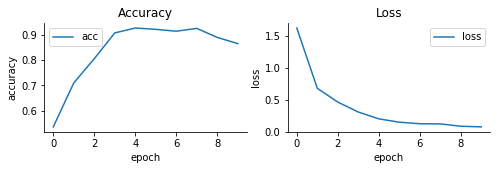

In [278]:
plot_training_curves(history.history)

In [241]:
m=model.predict(test_feats)

In [243]:
score = model.evaluate(test_feats,y_test["new_senti"], batch_size=128, verbose=2)
score[1]

0.5880597052289479

In [246]:
from sklearn.metrics.pairwise import cosine_similarity
cx= m.reshape(1,-1)
cy= y_test['new_senti'].reshape(1,-1)

C:\Users\PRPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [247]:
cosine_similarity(cx,cy)

array([[ 0.81846746]])

In [282]:
X_test['Sentimentscore']=y_test['sentimentscore']
X_test['Prediction']=m


In [287]:
Finaloutput1 = X_test.drop(['merged_spans','pos_count','neg_count','stockLex_Pos','stockLex_Neg'], 1)


In [288]:
Finaloutput1.head(10)

,id,cashtag,source,spans,Sentimentscore,Prediction
447,719573068864032768,$HZNP,twitter,"[plus its Irish based, getting rid of its gen...",0.226,0.999884
752,14646229,$NEPT,stocktwits,[gets a patent and goes up .20 today],0.432,0.999884
1133,7211448,$PNC,stocktwits,[Dividend Hike Green Light],0.316,0.999884
546,7764961,$AAPL,stocktwits,"[Added., Bounce off of, for ride to]",0.470,0.999884
1644,32427089,$ELN,stocktwits,[Quality Stocks With High Cash Returns],0.274,0.999884
138,719619301754273792,$YHOO,twitter,"[Bad governance, not confident in core biz]",-0.331,0.999884
577,719640388731068416,$TSLA,twitter,[Bullshit],-0.209,0.999884
72,5588045,$FXP,stocktwits,[Add to $FXP $SKF positions],0.500,0.999884
349,719578962985381888,$AGN,twitter,[I'll take the other side of that trade],0.422,0.999884
296,23970758,$WMB,stocktwits,[New recommendation from Carl Kirst of BMO Cap...,0.566,0.999884


# MODEL 2 - CNN 

In [290]:
model2 = Sequential()
from keras.optimizers import Adam
model2.add(Conv1D(64, kernel_size=3, activation='tanh', padding='same', input_shape=(1767,1)))
model2.add(Conv1D(120, kernel_size=3, activation='tanh', padding='same'))
model2.add(Dropout(0.5))
model2.add(Conv1D(90, kernel_size=3, activation='sigmoid', padding='same'))
model2.add(Dropout(0.25))
model2.add(Conv1D(180, kernel_size=2, activation='sigmoid', padding='same'))
model2.add(Dropout(0.5))
model2.add(Conv1D(64, kernel_size=2, activation='sigmoid', padding='same'))
model2.add(Conv1D(32, kernel_size=2, activation='tanh', padding='same'))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(256, activation='tanh'))
model2.add(Dense(256, activation='tanh'))
model2.add(Dropout(0.5))

model2.add(Dense(1, activation='tanh'))

In [306]:
model2.compile(optimizer='adam',
              loss='cosine_proximity',
              metrics=['accuracy'])

In [307]:
print('Train...')
model2.fit(train_feats2, y_train['new_senti'],
          batch_size=batch_size,
          epochs=15,
         )


Train...
Epoch 1/15
1338/1338 [==============================] - ETA: 438s - loss: -0.5312 - acc: 0.56 - ETA: 289s - loss: -0.5000 - acc: 0.51 - ETA: 241s - loss: -0.6042 - acc: 0.61 - ETA: 214s - loss: -0.6172 - acc: 0.62 - ETA: 196s - loss: -0.6437 - acc: 0.65 - ETA: 182s - loss: -0.6562 - acc: 0.66 - ETA: 173s - loss: -0.6384 - acc: 0.64 - ETA: 164s - loss: -0.6484 - acc: 0.65 - ETA: 155s - loss: -0.6493 - acc: 0.65 - ETA: 148s - loss: -0.6469 - acc: 0.65 - ETA: 141s - loss: -0.6534 - acc: 0.65 - ETA: 136s - loss: -0.6510 - acc: 0.65 - ETA: 130s - loss: -0.6538 - acc: 0.65 - ETA: 124s - loss: -0.6652 - acc: 0.66 - ETA: 118s - loss: -0.6583 - acc: 0.66 - ETA: 113s - loss: -0.6543 - acc: 0.65 - ETA: 108s - loss: -0.6581 - acc: 0.65 - ETA: 103s - loss: -0.6597 - acc: 0.66 - ETA: 99s - loss: -0.6562 - acc: 0.6579 - ETA: 94s - loss: -0.6625 - acc: 0.664 - ETA: 90s - loss: -0.6562 - acc: 0.657 - ETA: 86s - loss: -0.6619 - acc: 0.663 - ETA: 81s - loss: -0.6617 - acc: 0.663 - ETA: 77s - los

1338/1338 [==============================] - ETA: 153s - loss: -0.5312 - acc: 0.53 - ETA: 153s - loss: -0.5000 - acc: 0.50 - ETA: 147s - loss: -0.5417 - acc: 0.54 - ETA: 144s - loss: -0.5547 - acc: 0.55 - ETA: 140s - loss: -0.6125 - acc: 0.61 - ETA: 137s - loss: -0.6198 - acc: 0.61 - ETA: 133s - loss: -0.6384 - acc: 0.63 - ETA: 130s - loss: -0.6406 - acc: 0.64 - ETA: 125s - loss: -0.6354 - acc: 0.63 - ETA: 122s - loss: -0.6281 - acc: 0.62 - ETA: 118s - loss: -0.6392 - acc: 0.63 - ETA: 114s - loss: -0.6458 - acc: 0.64 - ETA: 110s - loss: -0.6394 - acc: 0.63 - ETA: 106s - loss: -0.6473 - acc: 0.64 - ETA: 102s - loss: -0.6458 - acc: 0.64 - ETA: 98s - loss: -0.6465 - acc: 0.6465 - ETA: 95s - loss: -0.6562 - acc: 0.656 - ETA: 91s - loss: -0.6528 - acc: 0.652 - ETA: 87s - loss: -0.6513 - acc: 0.651 - ETA: 83s - loss: -0.6562 - acc: 0.656 - ETA: 79s - loss: -0.6533 - acc: 0.653 - ETA: 76s - loss: -0.6577 - acc: 0.657 - ETA: 72s - loss: -0.6535 - acc: 0.653 - ETA: 68s - loss: -0.6523 - acc: 0.

1338/1338 [==============================] - ETA: 155s - loss: -0.6875 - acc: 0.68 - ETA: 151s - loss: -0.6406 - acc: 0.64 - ETA: 149s - loss: -0.6562 - acc: 0.65 - ETA: 144s - loss: -0.7031 - acc: 0.70 - ETA: 141s - loss: -0.6875 - acc: 0.68 - ETA: 155s - loss: -0.6875 - acc: 0.68 - ETA: 149s - loss: -0.6786 - acc: 0.67 - ETA: 144s - loss: -0.6875 - acc: 0.68 - ETA: 138s - loss: -0.6944 - acc: 0.69 - ETA: 133s - loss: -0.6844 - acc: 0.68 - ETA: 127s - loss: -0.6761 - acc: 0.67 - ETA: 123s - loss: -0.6693 - acc: 0.66 - ETA: 118s - loss: -0.6611 - acc: 0.66 - ETA: 113s - loss: -0.6473 - acc: 0.64 - ETA: 109s - loss: -0.6479 - acc: 0.64 - ETA: 104s - loss: -0.6484 - acc: 0.64 - ETA: 100s - loss: -0.6489 - acc: 0.64 - ETA: 95s - loss: -0.6476 - acc: 0.6476 - ETA: 91s - loss: -0.6464 - acc: 0.646 - ETA: 87s - loss: -0.6516 - acc: 0.651 - ETA: 83s - loss: -0.6518 - acc: 0.651 - ETA: 79s - loss: -0.6463 - acc: 0.646 - ETA: 75s - loss: -0.6481 - acc: 0.648 - ETA: 71s - loss: -0.6510 - acc: 0.

1338/1338 [==============================] - ETA: 156s - loss: -0.6875 - acc: 0.68 - ETA: 152s - loss: -0.5781 - acc: 0.57 - ETA: 148s - loss: -0.5937 - acc: 0.59 - ETA: 145s - loss: -0.6094 - acc: 0.60 - ETA: 141s - loss: -0.6375 - acc: 0.63 - ETA: 138s - loss: -0.6406 - acc: 0.64 - ETA: 134s - loss: -0.6518 - acc: 0.65 - ETA: 130s - loss: -0.6523 - acc: 0.65 - ETA: 126s - loss: -0.6458 - acc: 0.64 - ETA: 122s - loss: -0.6500 - acc: 0.65 - ETA: 118s - loss: -0.6449 - acc: 0.64 - ETA: 114s - loss: -0.6589 - acc: 0.65 - ETA: 111s - loss: -0.6611 - acc: 0.66 - ETA: 107s - loss: -0.6674 - acc: 0.66 - ETA: 103s - loss: -0.6646 - acc: 0.66 - ETA: 99s - loss: -0.6719 - acc: 0.6719 - ETA: 95s - loss: -0.6765 - acc: 0.676 - ETA: 91s - loss: -0.6719 - acc: 0.671 - ETA: 87s - loss: -0.6661 - acc: 0.666 - ETA: 84s - loss: -0.6578 - acc: 0.657 - ETA: 83s - loss: -0.6607 - acc: 0.660 - ETA: 79s - loss: -0.6548 - acc: 0.654 - ETA: 75s - loss: -0.6535 - acc: 0.653 - ETA: 70s - loss: -0.6562 - acc: 0.

In [308]:
m2=model2.predict(test_feats2)

In [309]:
score = model.evaluate(test_feats2,y_test["new_senti"], batch_size=128, verbose=2)
score[1]

ValueError: Error when checking input: expected dense_74_input to have 2 dimensions, but got array with shape (335, 1767, 1)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cx= m.reshape(1,-1)
cy= y_test['new_senti'].reshape(1,-1)

In [ ]:
cosine_similarity(cx,cy)

# MODEL 3 -LSTM 

In [ ]:
print('Build model...')
from keras.optimizers import RMSprop
model = Sequential()
# We'll have 128 hidden LSTM units -- each learning a different mapping from history + current sentence. 
model.add(LSTM(128,  input_shape=(1767,1) ))
# and then map to 59 outputs
model.add(Dense(1))
# as usual, normalized into a valid distribution using softmax 
model.add(Activation('tanh'))

model.compile(optimizer='adam',
              loss='cosine_proximity',
              metrics=['accuracy'])

In [ ]:
print('Train...')
model.fit(train_feats2, y_train['new_senti'],
          batch_size=batch_size,
          epochs=5,
         )
